##### Jack's Car Rental 

**problems:**  
1 不同的rent number和return number会导致相同的state对应不用的value，能不能做加权平均？更新的policy evaluation的时候没有问题，但是在policy improvement的时候会出问题吗？不会，这个是在action内部处理的问题。但是要注意pr与ps更新的顺序。

evaluation step max_values_changes: 243.142210133
evaluation step max_values_changes: 231.766647722
evaluation step max_values_changes: 208.457016204
evaluation step max_values_changes: 189.349800153
evaluation step max_values_changes: 174.406023203
evaluation step max_values_changes: 162.468111068
evaluation step max_values_changes: 152.791022953
evaluation step max_values_changes: 144.891394704
evaluation step max_values_changes: 138.421655353
evaluation step max_values_changes: 133.11479258
evaluation step max_values_changes: 128.758582816
evaluation step max_values_changes: 125.18147416
evaluation step max_values_changes: 122.243635435
evaluation step max_values_changes: 119.830630735
evaluation step max_values_changes: 117.848625968
evaluation step max_values_changes: 116.220608911
evaluation step max_values_changes: 114.883345789
evaluation step max_values_changes: 113.784905332
evaluation step max_values_changes: 112.882634344
evaluation step max_values_changes: 112.141498436
ev

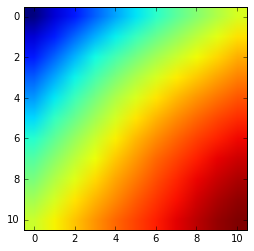

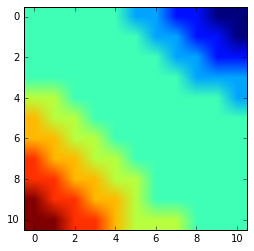

In [167]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

'''definations:
    state:[n_carA, n_carB]
    action:n_carFromAtoB
    '''
max_n = 10
max_n_m = 5

def possion(lam, high):
    if high != 0:
        poss_change = range(1, high+1)
        p = map(lambda x: (lam**x * np.exp(-lam))/np.prod(range(1, x+1)), poss_change)
        p[-1] = 1 - sum(p) + p[-1]
        return poss_change, p
    else:
        return [0], [1]

class JackCR(object):
    
    def __init__(self):
        self.gamma = 0.9
        self.theta = 110
        self.values = dict()
        for a in range(0, max_n + 1):
            for b in range(0, max_n + 1):
                self.values[str(a) + '_' + str(b)] = 10*a + 10*b
    
    def compute_psr(self, stateA, stateB, action):
        pr_dict = dict()
#       update state after action
        stateA_afaction = stateA - action
        stateB_afaction = stateB + action
#       update state after renting
        n_rentA, poss_rentA = possion(3, stateA_afaction)
        n_rentB, poss_rentB = possion(4, stateB_afaction)
        stateA_afrent = map(lambda n_rent: stateA_afaction - n_rent, n_rentA)
        stateB_afrent = map(lambda n_rent: stateB_afaction - n_rent, n_rentB)
#       compute state after returning
        ps_A = dict()
        ps_B = dict()
        pr_A = dict()
        pr_B = dict()
        
        for n_rA, sA_afrent, poss_rent in zip(n_rentA, stateA_afrent, poss_rentA):
            n_returnA, poss_returnA = possion(3, max_n - sA_afrent)
            rewardA = n_rA * 10
            for n_rtnA, poss_return in zip(n_returnA, poss_returnA):
                stateA_afreturn = sA_afrent + n_rtnA
                possA_afreturn = poss_rent * poss_return
                if str(stateA_afreturn) in ps_A.keys():
                    pr_A[str(stateA_afreturn)] = (pr_A[str(stateA_afreturn)] * ps_A[str(stateA_afreturn)] +
                                                  rewardA * possA_afreturn)/(ps_A[str(stateA_afreturn)] + possA_afreturn)
                    ps_A[str(stateA_afreturn)] = ps_A[str(stateA_afreturn)] + possA_afreturn
                else:
                    ps_A[str(stateA_afreturn)] = possA_afreturn
                    pr_A[str(stateA_afreturn)] = rewardA

        for n_rB, sB_afrent, poss_rent in zip(n_rentB, stateB_afrent, poss_rentB):
            n_returnB, poss_returnB = possion(2, max_n - sB_afrent)
            rewardB = n_rB * 10
            for n_rtnB, poss_return in zip(n_returnB, poss_returnB):
                stateB_afreturn = sB_afrent + n_rtnB
                possB_afreturn = poss_rent * poss_return
                if str(stateB_afreturn) in ps_B.keys():
                    pr_B[str(stateB_afreturn)] = (pr_B[str(stateB_afreturn)] * ps_B[str(stateB_afreturn)] +
                                                  rewardB * possB_afreturn)/(ps_B[str(stateB_afreturn)] + possB_afreturn)
                    ps_B[str(stateB_afreturn)] = ps_B[str(stateB_afreturn)] + possB_afreturn
                else:
                    ps_B[str(stateB_afreturn)] = possB_afreturn
                    pr_B[str(stateB_afreturn)] = rewardB
                    
        ps = dict()
        for keyA, possA in zip(ps_A.keys(), ps_A.values()):
            for keyB, possB in zip(ps_B.keys(), ps_B.values()):
                key = keyA + '_' + keyB
                poss = possA * possB
                ps[key] = poss
                
        pr = dict()        
        for keyA, rewardA in zip(pr_A.keys(), pr_A.values()):
            for keyB, rewardB in zip(pr_B.keys(), pr_B.values()):
                key = keyA + '_' + keyB
                reward = rewardA + rewardB - abs(action) * 2
                pr[key] = reward
        return pr, ps
    
    def policy_improvement(self):
        self.policy = dict()
        for key in self.values.keys():
            stateA = int(key[:key.find('_')])
            stateB = int(key[key.find('_')+1:])
            action_avilable = range(-min(max_n_m, stateB, max_n - stateA), min(max_n_m + 1, stateA + 1, max_n - stateB + 1))
            q_actions = []
            for action in action_avilable:
                pr, ps = self.compute_psr(stateA, stateB, action)
                q = 0
                for key_sr in pr.keys():
                    q = q + ps[key_sr] * (pr[key_sr] + self.gamma * self.values[key_sr])
                q_actions.append(q)
            for i, q_temp in enumerate(q_actions):
                if q_temp == max(q_actions):
                    action = action_avilable[i]
            self.policy[key] = action
            
    def policy_evaluation(self):
        for key in self.values.keys():
            stateA = int(key[:key.find('_')])
            stateB = int(key[key.find('_')+1:])
            action = self.policy[key]
            pr, ps = self.compute_psr(stateA, stateB, action)
            q = 0
            for key_sr in pr.keys():
                q = q + ps[key_sr] * (pr[key_sr] + self.gamma * self.values[key_sr])
            self.values[key] = q
    
    def train(self):
        self.policy_improvement()
        policy_tmp = dict()
        while self.policy != policy_tmp:
            policy_tmp = self.policy.copy()
            evaluation_flag = True
            while evaluation_flag:
                values_temp = self.values.copy()
                self.policy_evaluation()
                max_values_changes = 0
                for a, b in zip(values_temp.values(), self.values.values()):
                    max_values_changes = max(max_values_changes, abs(a - b))
                if max_values_changes < self.theta:
                    evaluation_flag = False
                print 'evaluation step', 'max_values_changes:', max_values_changes
            self.policy_improvement()
            print ' '
            print 'improvement step'
        
                
                
                
    
test = JackCR()
# print test.value
# print test.compute_psr(10, 10, 5)
# test.policy_improvement()
# test.policy_evaluation()
test.train()
values = np.random.randn(max_n + 1, max_n + 1)
policies = np.random.randn(max_n + 1, max_n + 1)
for key, value in zip(test.values.keys(), test.values.values()):
    values[int(key[:key.find('_')]), int(key[key.find('_')+1:])] = value
for key_p, policy in zip(test.policy.keys(), test.policy.values()):
    policies[int(key_p[:key_p.find('_')]), int(key_p[key_p.find('_')+1:])] = policy

plt.imshow(values)
plt.show()
plt.imshow(policies)
plt.show()

In [ ]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

'''definations:
    state:[n_carA, n_carB]
    action:n_carFromAtoB
    '''
max_n = 20
max_n_m = 5
max_each_park = 10

def possion(lam, high):
    if high != 0:
        poss_change = range(1, high+1)
        p = map(lambda x: (lam**x * np.exp(-lam))/np.prod(range(1, x+1)), poss_change)
        p[-1] = 1 - sum(p) + p[-1]
        return poss_change, p
    else:
        return [0], [1]

class JackCR(object):
    
    def __init__(self):
        self.gamma = 0.9
        self.theta = 200
        self.values = dict()
        for a in range(0, max_n + 1):
            for b in range(0, max_n + 1):
                self.values[str(a) + '_' + str(b)] = 10*a + 10*b
    
    def compute_psr(self, stateA, stateB, action):
        pr_dict = dict()
#       update state after action
        stateA_afaction = stateA - action
        stateB_afaction = stateB + action
#       update state after renting
        n_rentA, poss_rentA = possion(3, stateA_afaction)
        n_rentB, poss_rentB = possion(4, stateB_afaction)
        stateA_afrent = map(lambda n_rent: stateA_afaction - n_rent, n_rentA)
        stateB_afrent = map(lambda n_rent: stateB_afaction - n_rent, n_rentB)
#       compute state after returning
        ps_A = dict()
        ps_B = dict()
        pr_A = dict()
        pr_B = dict()
        
        for n_rA, sA_afrent, poss_rent in zip(n_rentA, stateA_afrent, poss_rentA):
            n_returnA, poss_returnA = possion(3, max_n - sA_afrent)
            rewardA = n_rA * 10
            for n_rtnA, poss_return in zip(n_returnA, poss_returnA):
                stateA_afreturn = sA_afrent + n_rtnA
                possA_afreturn = poss_rent * poss_return
                if str(stateA_afreturn) in ps_A.keys():
                    pr_A[str(stateA_afreturn)] = (pr_A[str(stateA_afreturn)] * ps_A[str(stateA_afreturn)] +
                                                  rewardA * possA_afreturn)/(ps_A[str(stateA_afreturn)] + possA_afreturn)
                    ps_A[str(stateA_afreturn)] = ps_A[str(stateA_afreturn)] + possA_afreturn
                else:
                    ps_A[str(stateA_afreturn)] = possA_afreturn
                    pr_A[str(stateA_afreturn)] = rewardA

        for n_rB, sB_afrent, poss_rent in zip(n_rentB, stateB_afrent, poss_rentB):
            n_returnB, poss_returnB = possion(2, max_n - sB_afrent)
            rewardB = n_rB * 10
            for n_rtnB, poss_return in zip(n_returnB, poss_returnB):
                stateB_afreturn = sB_afrent + n_rtnB
                possB_afreturn = poss_rent * poss_return
                if str(stateB_afreturn) in ps_B.keys():
                    pr_B[str(stateB_afreturn)] = (pr_B[str(stateB_afreturn)] * ps_B[str(stateB_afreturn)] +
                                                  rewardB * possB_afreturn)/(ps_B[str(stateB_afreturn)] + possB_afreturn)
                    ps_B[str(stateB_afreturn)] = ps_B[str(stateB_afreturn)] + possB_afreturn
                else:
                    ps_B[str(stateB_afreturn)] = possB_afreturn
                    pr_B[str(stateB_afreturn)] = rewardB
                    
        ps = dict()
        for keyA, possA in zip(ps_A.keys(), ps_A.values()):
            for keyB, possB in zip(ps_B.keys(), ps_B.values()):
                key = keyA + '_' + keyB
                poss = possA * possB
                ps[key] = poss
                
        pr = dict()        
        for keyA, rewardA in zip(pr_A.keys(), pr_A.values()):
            for keyB, rewardB in zip(pr_B.keys(), pr_B.values()):
                key = keyA + '_' + keyB
                reward = rewardA + rewardB
                if stateA_afaction > max_each_park:
                    reward = reward - 4
                if stateB_afaction > max_each_park:
                    reward = reward - 4
                if action > 0:
                    reward = reward - 2 * abs(action) + 2
                else:
                    reward = reward - 2 * abs(action)
                pr[key] = reward
        return pr, ps
    
    def policy_improvement(self):
        self.policy = dict()
        for key in self.values.keys():
            stateA = int(key[:key.find('_')])
            stateB = int(key[key.find('_')+1:])
            action_avilable = range(-min(max_n_m, stateB, max_n - stateA), min(max_n_m + 1, stateA + 1, max_n - stateB + 1))
            q_actions = []
            for action in action_avilable:
                pr, ps = self.compute_psr(stateA, stateB, action)
                q = 0
                for key_sr in pr.keys():
                    q = q + ps[key_sr] * (pr[key_sr] + self.gamma * self.values[key_sr])
                q_actions.append(q)
            for i, q_temp in enumerate(q_actions):
                if q_temp == max(q_actions):
                    action = action_avilable[i]
            self.policy[key] = action
            
    def policy_evaluation(self):
        for key in self.values.keys():
            stateA = int(key[:key.find('_')])
            stateB = int(key[key.find('_')+1:])
            action = self.policy[key]
            pr, ps = self.compute_psr(stateA, stateB, action)
            q = 0
            for key_sr in pr.keys():
                q = q + ps[key_sr] * (pr[key_sr] + self.gamma * self.values[key_sr])
            self.values[key] = q
    
    def train(self):
        self.policy_improvement()
        policy_tmp = dict()
        while self.policy != policy_tmp:
            policy_tmp = self.policy.copy()
            evaluation_flag = True
            while evaluation_flag:
                values_temp = self.values.copy()
                self.policy_evaluation()
                max_values_changes = 0
                for a, b in zip(values_temp.values(), self.values.values()):
                    max_values_changes = max(max_values_changes, abs(a - b))
                if max_values_changes < self.theta:
                    evaluation_flag = False
                print 'evaluation step', 'max_values_changes:', max_values_changes
            self.policy_improvement()
            print ' '
            print 'improvement step'
        
                
                
                
    
test = JackCR()
# print test.value
# print test.compute_psr(10, 10, 5)
# test.policy_improvement()
# test.policy_evaluation()
test.train()
values = np.random.randn(max_n + 1, max_n + 1)
policies = np.random.randn(max_n + 1, max_n + 1)
for key, value in zip(test.values.keys(), test.values.values()):
    values[int(key[:key.find('_')]), int(key[key.find('_')+1:])] = value
for key_p, policy in zip(test.policy.keys(), test.policy.values()):
    policies[int(key_p[:key_p.find('_')]), int(key_p[key_p.find('_')+1:])] = policy

plt.imshow(values)
plt.show()
plt.imshow(policies)
plt.show()

evaluation step max_values_changes: 383.962042743
evaluation step max_values_changes: 336.481182596
evaluation step max_values_changes: 275.973797352
evaluation step max_values_changes: 232.517582909
evaluation step max_values_changes: 205.338587688
evaluation step max_values_changes: 188.17469932
